In [1]:
!pip install tableone

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from tableone import TableOne
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/scientometrics')

print("Current Working Directory:", os.getcwd())

Mounted at /content/drive
Current Working Directory: /content/drive/My Drive/scientometrics


In [3]:
df = pd.read_csv(f"clean/max_30_authors.csv")

In [4]:
df.head()

,pub_id,researcher_id,journal,year,gender,aff_country_code,aff_id,LMIC
0,pub.1000001707,ur.01006172666.33,JAMA,2015,female,US,grid.411024.2,0.0
1,pub.1000001707,ur.01012736025.78,JAMA,2015,male,US,NaN,0.0
2,pub.1000001707,ur.010132635727.81,JAMA,2015,male,US,grid.266102.1,0.0
3,pub.1000001707,ur.01023477132.25,JAMA,2015,female,US,grid.62560.37,0.0
4,pub.1000001707,ur.01043100547.54,JAMA,2015,female,US,grid.267308.8,0.0


## add mix cols

In [5]:
is_gender_mix = df.groupby('pub_id').apply(lambda x: ('male' in x.values) & \
                                                     ('female' in x.values)) \
                                    .reset_index(name='gender_mix')

is_country_mix = df.groupby('pub_id').LMIC \
                   .apply(list) \
                   .apply(lambda x: 0.0 in x and 1.0 in x) \
                   .reset_index(name='country_mix')

merged_df = pd.merge(df, is_gender_mix, how='left', on='pub_id')
merged_df = pd.merge(merged_df, is_country_mix, how='left', on='pub_id')

## author-level, conditional on gender/income

### confidence intervals gender -- all

In [ ]:
import numpy as np
import pandas as pd

def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  prob_gender = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

prob_gender

100%|██████████| 100/100 [14:39<00:00,  8.79s/it]


,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.167917,0.167966,0.003144,0.002892
1,male,0.180714,0.180690,0.001747,0.001649


### subset to gender mix teams

In [11]:
df = merged_df.loc[merged_df.gender_mix == True]

In [12]:
len(df)

225808

### gender analysis

#### no split

In [11]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [09:30<00:00,  5.70s/it]


In [12]:
results_df_authors

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.150402,0.150591,0.003280,0.003431
1,male,0.130355,0.130240,0.002055,0.002220


#### 3+ authors

In [8]:
mask_authors0 = df.groupby('pub_id').researcher_id.count() >= 3

df_authors0 = df.loc[df['pub_id'].isin(mask_authors0[mask_authors0].index)]

In [9]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors0.sample(n=len(df_authors0), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors0 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [07:33<00:00,  4.54s/it]


In [10]:
results_df_authors0

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.130275,0.130527,0.003159,0.003339
1,male,0.117788,0.117639,0.002137,0.001836


#### 2-3 authors

In [55]:
mask_authors1 = df.groupby('pub_id').researcher_id.count() <= 3

df_authors1 = df.loc[df['pub_id'].isin(mask_authors1[mask_authors1].index)]

In [56]:
len(df_authors1) / len(df)

0.23402107857719603

In [57]:
df_authors1.gender.value_counts(normalize=True)

male      0.71213
female    0.28787
Name: gender, dtype: float64

In [58]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors1.sample(n=len(df_authors1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors1 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [07:27<00:00,  4.47s/it]


In [59]:
results_df_authors1

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.385305,0.385452,0.010817,0.010541
1,male,0.386628,0.386566,0.005021,0.005062


#### 4-5 authors

In [60]:
mask_authors2 = df.groupby('pub_id')['researcher_id'].count().isin([4, 5])

df_authors2 = df.loc[df['pub_id'].isin(mask_authors2[mask_authors2].index)]

In [61]:
df_authors2.gender.value_counts(normalize=True)

male      0.664817
female    0.335183
Name: gender, dtype: float64

In [62]:
len(df_authors2) / len(df)

0.12245902568243311

In [63]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors2.sample(n=len(df_authors2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors2 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


In [64]:
results_df_authors2

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.237011,0.236979,0.01170,0.010489
1,male,0.236997,0.237012,0.00659,0.005755


#### 6+ authors

In [65]:
mask_authors3 = df.groupby('pub_id')['researcher_id'].count() >= 6

df_authors3 = df.loc[df['pub_id'].isin(mask_authors3[mask_authors3].index)]

In [66]:
df_authors3.gender.value_counts(normalize=True)

male      0.654024
female    0.345976
Name: gender, dtype: float64

In [67]:
len(df_authors3) / len(df)

0.6435198957403708

In [68]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors3.sample(n=len(df_authors3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors3 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [04:10<00:00,  2.50s/it]


In [69]:
results_df_authors3

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.088026,0.088157,0.003324,0.003311
1,male,0.087012,0.086942,0.001704,0.001808


#### before dec 2015

In [70]:
mask_years1 = df.year <= 2015

df_years1 = df.loc[mask_years1]

In [71]:
df_years1.gender.value_counts(normalize=True)

male      0.695542
female    0.304458
Name: gender, dtype: float64

In [72]:
len(df_years1) / len(df)

0.44155936140977153

In [73]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years1.sample(n=len(df_years1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years1 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [06:12<00:00,  3.73s/it]


In [74]:
results_df_years1

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.177658,0.177881,0.005326,0.005665
1,male,0.192586,0.192489,0.002718,0.002936


#### between jan 2016 - dec 2019

In [75]:
mask_years2 = df.year.isin([2016, 2017, 2018, 2019])

df_years2 = df.loc[mask_years2]

In [76]:
df_years2.gender.value_counts(normalize=True)

male      0.663351
female    0.336649
Name: gender, dtype: float64

In [77]:
len(df_years2) / len(df)

0.3153570467326789

In [78]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years2.sample(n=len(df_years2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years2 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


In [79]:
results_df_years2

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.164783,0.164987,0.005784,0.007412
1,male,0.176105,0.176000,0.003012,0.004077


#### after jan 2020

In [80]:
mask_years3 = df.year >= 2020

df_years3 = df.loc[mask_years3]

In [81]:
df_years3.gender.value_counts(normalize=True)

male      0.627699
female    0.372301
Name: gender, dtype: float64

In [82]:
len(df_years3) / len(df)

0.2430835918575496

In [83]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years3.sample(n=len(df_years3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years3 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


In [84]:
results_df_years3

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.156770,0.156699,0.006607,0.005633
1,male,0.162663,0.162704,0.004765,0.003345


### country analysis

#### no split

In [13]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [09:09<00:00,  5.50s/it]


In [14]:
results_df_authors_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.119648,0.119371,0.004580,0.004399
1,HIC,0.130773,0.130803,0.000832,0.000739


#### 3+ authors

In [13]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors0.sample(n=len(df_authors0), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors0_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [08:04<00:00,  4.85s/it]


In [14]:
results_df_authors0_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.109813,0.109571,0.005213,0.004548
1,HIC,0.115424,0.115450,0.000645,0.000652


#### 2-3 authors

In [192]:
mask_authors1 = df.groupby('pub_id').researcher_id.count() <= 3

df_authors1 = df.loc[df['pub_id'].isin(mask_authors1[mask_authors1].index)]

In [193]:
df_authors1.LMIC.value_counts(normalize=True)

0.0    0.934146
1.0    0.065854
Name: LMIC, dtype: float64

In [194]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors1.sample(n=len(df_authors1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors1_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


In [195]:
results_df_authors1_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.360322,0.360171,0.034946,0.032548
1,HIC,0.362366,0.362378,0.004511,0.004366


#### 4-5 authors

In [196]:
mask_authors2 = df.groupby('pub_id')['researcher_id'].count().isin([4, 5])

df_authors2 = df.loc[df['pub_id'].isin(mask_authors2[mask_authors2].index)]

In [197]:
df_authors2.LMIC.value_counts(normalize=True)

0.0    0.896938
1.0    0.103062
Name: LMIC, dtype: float64

In [198]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors2.sample(n=len(df_authors2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors2_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


In [199]:
results_df_authors2_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.220755,0.221560,0.022479,0.022586
1,HIC,0.223369,0.223276,0.002697,0.002657


#### 5+ authors

In [200]:
mask_authors3 = df.groupby('pub_id')['researcher_id'].count() >= 6

df_authors3 = df.loc[df['pub_id'].isin(mask_authors3[mask_authors3].index)]

In [201]:
df_authors3.LMIC.value_counts(normalize=True)

0.0    0.898448
1.0    0.101552
Name: LMIC, dtype: float64

In [202]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors3.sample(n=len(df_authors3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors3_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


In [203]:
results_df_authors3_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.080223,0.07997,0.005197,0.004365
1,HIC,0.079152,0.07918,0.000586,0.000486


#### before dec 2015

In [204]:
mask_years1 = df.year <= 2015

df_years1 = df.loc[mask_years1]

In [205]:
df_years1.LMIC.value_counts(normalize=True)

0.0    0.915507
1.0    0.084493
Name: LMIC, dtype: float64

In [206]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years1.sample(n=len(df_years1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years1_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [03:55<00:00,  2.36s/it]


In [207]:
results_df_years1_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.123831,0.124010,0.009152,0.007860
1,HIC,0.141631,0.141614,0.001243,0.001226


#### between jan 2016 - dec 2019

In [208]:
mask_years2 = df.year.isin([2016, 2017, 2018, 2019])

df_years2 = df.loc[mask_years2]

In [209]:
df_years2.LMIC.value_counts(normalize=True)

0.0    0.892102
1.0    0.107898
Name: LMIC, dtype: float64

In [210]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years2.sample(n=len(df_years2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years2_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


In [211]:
results_df_years2_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.123163,0.122964,0.008116,0.009672
1,HIC,0.125212,0.125236,0.001176,0.001363


#### after jan 2020

In [212]:
mask_years3 = df.year >= 2020

df_years3 = df.loc[mask_years3]

In [213]:
df_years3.LMIC.value_counts(normalize=True)

0.0    0.894655
1.0    0.105345
Name: LMIC, dtype: float64

In [214]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years3.sample(n=len(df_years3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years3_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


In [215]:
results_df_years3_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.109377,0.109538,0.009503,0.008261
1,HIC,0.119357,0.119338,0.001539,0.001457


### confidence intervals lmic -- all

In [85]:
import numpy as np
import pandas as pd

def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors1 = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

prob_lmic_hic

100%|██████████| 100/100 [12:10<00:00,  7.31s/it]


,Category,Probability_First_Author,Probability_Last_Author
0,LMIC,16.243712,16.161729
1,HIC,17.940845,17.94955
2,Significant,Yes,Yes


In [ ]:
# ignore this run just above

### subset to country mix teams

In [15]:
df = merged_df.loc[merged_df.country_mix == True]

In [16]:
len(df)

49856

### country analysis

#### no split

In [17]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [18]:
results_df_authors_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.118342,0.118764,0.006651,0.006493
1,HIC,0.099564,0.099337,0.003504,0.003515


#### 3+ authors

In [17]:
mask_authors0 = df.groupby('pub_id').researcher_id.count() >= 3

df_authors0 = df.loc[df['pub_id'].isin(mask_authors0[mask_authors0].index)]

In [18]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors0.sample(n=len(df_authors0), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors0_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


In [19]:
results_df_authors0_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.108008,0.107735,0.007246,0.007898
1,HIC,0.093079,0.093223,0.003701,0.004075


#### 2-3 authors

In [132]:
mask_authors1 = df.groupby('pub_id').researcher_id.count() <= 3

df_authors1 = df.loc[df['pub_id'].isin(mask_authors1[mask_authors1].index)]

In [133]:
df_authors1.LMIC.value_counts(normalize=True)

0.0    0.529487
1.0    0.470513
Name: LMIC, dtype: float64

In [134]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors1.sample(n=len(df_authors1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors1_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


In [135]:
results_df_authors1_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.363798,0.362449,0.033144,0.035536
1,HIC,0.357444,0.358664,0.028047,0.026463


#### 4-5 authors

In [136]:
mask_authors2 = df.groupby('pub_id')['researcher_id'].count().isin([4, 5])

df_authors2 = df.loc[df['pub_id'].isin(mask_authors2[mask_authors2].index)]

In [137]:
df_authors2.LMIC.value_counts(normalize=True)

0.0    0.577564
1.0    0.422436
Name: LMIC, dtype: float64

In [138]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors2.sample(n=len(df_authors2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors2_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


In [139]:
results_df_authors2_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.219635,0.220634,0.025883,0.028913
1,HIC,0.220337,0.219591,0.019040,0.020254


#### 5+ authors

In [140]:
mask_authors3 = df.groupby('pub_id')['researcher_id'].count() >= 6

df_authors3 = df.loc[df['pub_id'].isin(mask_authors3[mask_authors3].index)]

In [141]:
df_authors3.LMIC.value_counts(normalize=True)

0.0    0.665966
1.0    0.334034
Name: LMIC, dtype: float64

In [142]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors3.sample(n=len(df_authors3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors3_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


In [143]:
results_df_authors3_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.078918,0.078977,0.006190,0.005363
1,HIC,0.072642,0.072613,0.003161,0.002816


#### before dec 2015

In [144]:
mask_years1 = df.year <= 2015

df_years1 = df.loc[mask_years1]

In [145]:
df_years1.LMIC.value_counts(normalize=True)

0.0    0.641107
1.0    0.358893
Name: LMIC, dtype: float64

In [146]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years1.sample(n=len(df_years1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years1_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


In [147]:
results_df_years1_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.129233,0.128531,0.011054,0.009414
1,HIC,0.111246,0.111640,0.005781,0.005648


#### between jan 2016 - dec 2019

In [148]:
mask_years2 = df.year.isin([2016, 2017, 2018, 2019])

df_years2 = df.loc[mask_years2]

In [149]:
df_years2.LMIC.value_counts(normalize=True)

0.0    0.641505
1.0    0.358495
Name: LMIC, dtype: float64

In [150]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years2.sample(n=len(df_years2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years2_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


In [151]:
results_df_years2_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.114167,0.114033,0.01067,0.010304
1,HIC,0.093005,0.093079,0.00604,0.006308


#### after jan 2020

In [152]:
mask_years3 = df.year >= 2020

df_years3 = df.loc[mask_years3]

In [153]:
df_years3.LMIC.value_counts(normalize=True)

0.0    0.669906
1.0    0.330094
Name: LMIC, dtype: float64

In [154]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    lmic_hic_list = group['LMIC'].dropna().tolist()
    total_counts['LMIC'] += lmic_hic_list.count(1.0)
    total_counts['HIC'] += lmic_hic_list.count(0.0)

    if lmic_hic_list:
        first = 'LMIC' if lmic_hic_list[0] == 1.0 else 'HIC'
        first_author_counts[first] += 1

        last = 'LMIC' if lmic_hic_list[-1] == 1.0 else 'HIC'
        last_author_counts[last] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_lmic': [],
    'first_hic': [],
    'last_lmic': [],
    'last_hic': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years3.sample(n=len(df_years3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'LMIC': 0, 'HIC': 0}
  last_author_counts = {'LMIC': 0, 'HIC': 0}
  total_counts = {'LMIC': 0, 'HIC': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_lmic'].append(prob_first_author['LMIC'])
  bootstrap_results['first_hic'].append(prob_first_author['HIC'])
  bootstrap_results['last_lmic'].append(prob_last_author['LMIC'])
  bootstrap_results['last_hic'].append(prob_last_author['HIC'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years3_lmic = pd.DataFrame({
  'Category': ['LMIC', 'HIC'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_lmic']), np.mean(bootstrap_results['first_hic'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_lmic']), np.mean(bootstrap_results['last_hic'])],
  'CI_First_Author': [confidence_intervals['first_lmic'], confidence_intervals['first_hic']],
  'CI_Last_Author': [confidence_intervals['last_lmic'], confidence_intervals['last_hic']]
  })

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


In [155]:
results_df_years3_lmic

,Category,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,LMIC,0.108996,0.109296,0.011320,0.011583
1,HIC,0.090687,0.090541,0.005816,0.006191


### gender analysis

#### no split

In [19]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df.sample(n=len(df), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


In [20]:
results_df_authors

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.115796,0.115325,0.007809,0.007803
1,male,0.117345,0.117584,0.003767,0.003744


#### 3+ authors

In [20]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors0.sample(n=len(df_authors0), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors0 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [21]:
results_df_authors0

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.108042,0.107942,0.007601,0.006623
1,male,0.108996,0.109047,0.003947,0.003534


#### 2-3 authors

In [158]:
mask_authors1 = df.groupby('pub_id').researcher_id.count() <= 3

df_authors1 = df.loc[df['pub_id'].isin(mask_authors1[mask_authors1].index)]

In [159]:
len(df_authors1) / len(df)

0.0629813863928113

In [160]:
df_authors1.gender.value_counts(normalize=True)

male      0.689194
female    0.310806
Name: gender, dtype: float64

In [161]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors1.sample(n=len(df_authors1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors1 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


In [162]:
results_df_authors1

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.379128,0.379104,0.048997,0.046068
1,male,0.380774,0.380809,0.026576,0.025583


#### 4-5 authors

In [163]:
mask_authors2 = df.groupby('pub_id')['researcher_id'].count().isin([4, 5])

df_authors2 = df.loc[df['pub_id'].isin(mask_authors2[mask_authors2].index)]

In [164]:
df_authors2.gender.value_counts(normalize=True)

male      0.67194
female    0.32806
Name: gender, dtype: float64

In [165]:
len(df_authors2) / len(df)

0.09174422336328626

In [166]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors2.sample(n=len(df_authors2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors2 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


In [167]:
results_df_authors2

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.243273,0.243570,0.028928,0.029217
1,male,0.240466,0.240341,0.013924,0.015250


#### 6+ authors

In [168]:
mask_authors3 = df.groupby('pub_id')['researcher_id'].count() >= 6

df_authors3 = df.loc[df['pub_id'].isin(mask_authors3[mask_authors3].index)]

In [169]:
df_authors3.gender.value_counts(normalize=True)

male      0.660004
female    0.339996
Name: gender, dtype: float64

In [170]:
len(df_authors3) / len(df)

0.8452743902439024

In [171]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_authors3.sample(n=len(df_authors3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_authors3 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


In [172]:
results_df_authors3

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.083678,0.083381,0.006289,0.006266
1,male,0.082931,0.083086,0.003341,0.003254


#### before dec 2015

In [173]:
mask_years1 = df.year <= 2015

df_years1 = df.loc[mask_years1]

In [174]:
df_years1.gender.value_counts(normalize=True)

male      0.693714
female    0.306286
Name: gender, dtype: float64

In [175]:
len(df_years1) / len(df)

0.3898226893453145

In [176]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years1.sample(n=len(df_years1), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years1 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


In [177]:
results_df_years1

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.124059,0.124288,0.012540,0.013072
1,male,0.130409,0.130304,0.005805,0.006416


#### between jan 2016 - dec 2019

In [178]:
mask_years2 = df.year.isin([2016, 2017, 2018, 2019])

df_years2 = df.loc[mask_years2]

In [179]:
df_years2.gender.value_counts(normalize=True)

male      0.661187
female    0.338813
Name: gender, dtype: float64

In [180]:
len(df_years2) / len(df)

0.3337612323491656

In [181]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years2.sample(n=len(df_years2), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years2 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


In [182]:
results_df_years2

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.111221,0.111361,0.013062,0.013140
1,male,0.111594,0.111523,0.006598,0.006579


#### after jan 2020

In [183]:
mask_years3 = df.year >= 2020

df_years3 = df.loc[mask_years3]

In [184]:
df_years3.gender.value_counts(normalize=True)

male      0.621171
female    0.378829
Name: gender, dtype: float64

In [185]:
len(df_years3) / len(df)

0.2764160783055199

In [186]:
def update_counts(group):
    global first_author_counts, last_author_counts, total_counts

    gender_list = group['gender'].dropna().tolist()
    total_counts['female'] += gender_list.count('female')
    total_counts['male'] += gender_list.count('male')

    if gender_list:
        first_author_counts[gender_list[0]] += 1
        last_author_counts[gender_list[-1]] += 1

# Initialize the bootstrap parameters
n_bootstraps = 100

# Prepare bootstrap results storage
bootstrap_results = {
    'first_female': [],
    'first_male': [],
    'last_female': [],
    'last_male': []
}

for i in tqdm(range(n_bootstraps)):
  # Sample data with replacement
  bootstrap_sample = df_years3.sample(n=len(df_years3), replace=True)

  # Initialize counts for this bootstrap sample
  first_author_counts = {'female': 0, 'male': 0}
  last_author_counts = {'female': 0, 'male': 0}
  total_counts = {'female': 0, 'male': 0}

  # Apply function to each group in the bootstrap sample
  bootstrap_sample.groupby('pub_id').apply(update_counts)

  # Calculate probabilities for this bootstrap sample
  prob_first_author = {k: (v / total_counts[k]) for k, v in first_author_counts.items()}
  prob_last_author = {k: (v / total_counts[k]) for k, v in last_author_counts.items()}

  # Store the probabilities
  bootstrap_results['first_female'].append(prob_first_author['female'])
  bootstrap_results['first_male'].append(prob_first_author['male'])
  bootstrap_results['last_female'].append(prob_last_author['female'])
  bootstrap_results['last_male'].append(prob_last_author['male'])

  confidence_intervals = {k: (np.percentile(v, 97.5) - np.percentile(v, 2.5)) for k, v in bootstrap_results.items()}

  results_df_years3 = pd.DataFrame({
  'Gender': ['female', 'male'],
  'Probability_First_Author': [np.mean(bootstrap_results['first_female']), np.mean(bootstrap_results['first_male'])],
  'Probability_Last_Author': [np.mean(bootstrap_results['last_female']), np.mean(bootstrap_results['last_male'])],
  'CI_First_Author': [confidence_intervals['first_female'], confidence_intervals['first_male']],
  'CI_Last_Author': [confidence_intervals['last_female'], confidence_intervals['last_male']]
  })

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


In [187]:
results_df_years3

,Gender,Probability_First_Author,Probability_Last_Author,CI_First_Author,CI_Last_Author
0,female,0.109772,0.110252,0.011904,0.011416
1,male,0.104826,0.104529,0.007518,0.007220


### plot

In [ ]:
def add_asterisks(ax, rects1, rects2):
    for rect1, rect2 in zip(rects1, rects2):
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        max_height = max(height1, height2)
        ax.text(rect1.get_x() + rect1.get_width(), max_height + 2, '*',
                ha='center', fontweight='bold')

def add_values(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

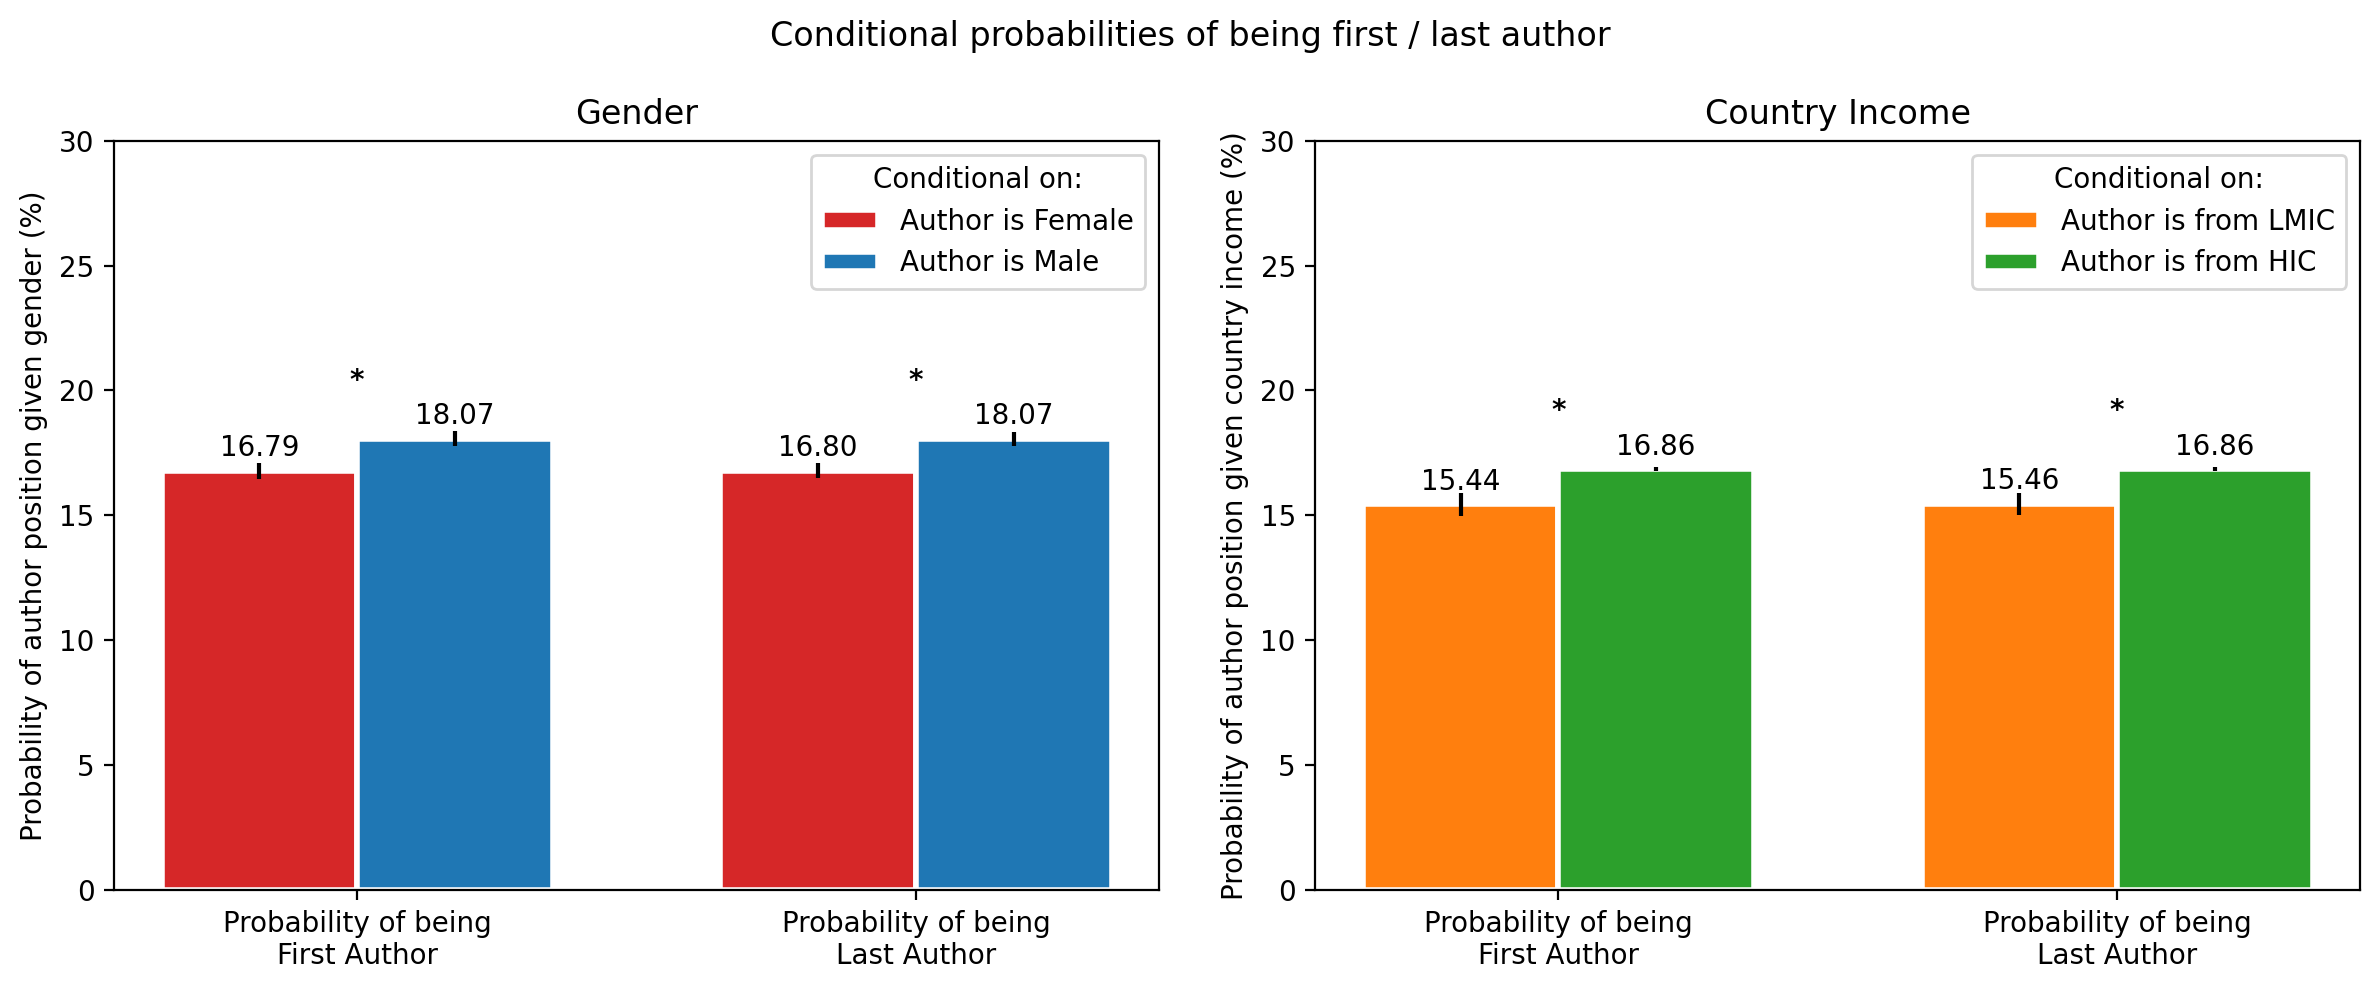

In [ ]:
# Data for gender
gender_labels = ['Probability of being\nFirst Author',
                 'Probability of being\nLast Author']
gender_minorities = [
    prob_gender.loc[prob_gender['Gender'] == 'female', 'Probability_First_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'female', 'Probability_Last_Author'].iloc[0]*100,
]
ci_g_minorities = [
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_First_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_Last_Author'].iloc[0]*100,
]

gender_majorities = [
    prob_gender.loc[prob_gender['Gender'] == 'male', 'Probability_First_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'male', 'Probability_Last_Author'].iloc[0]*100,
]

ci_g_majorities = [
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_Last_Author'].iloc[0]*100,
    prob_gender.loc[prob_gender['Gender'] == 'female', 'CI_Last_Author'].iloc[0]*100,
]

# Data for income
income_labels = ['Probability of being\nFirst Author',
                 'Probability of being\nLast Author']
income_minorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'Probability_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'Probability_Last_Author'].iloc[0]*100,
]

ci_i_minorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'CI_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'LMIC', 'CI_Last_Author'].iloc[0]*100,
]

income_majorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'Probability_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'Probability_Last_Author'].iloc[0]*100,
]
ci_i_majorities = [
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'CI_First_Author'].iloc[0]*100,
    prob_lmic_hic.loc[prob_lmic_hic['Category'] == 'HIC', 'CI_Last_Author'].iloc[0]*100,
]


# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting Gender
x_gender = np.arange(len(gender_labels))
width = 0.35
rects1_gender = ax1.bar(x_gender - width/2, gender_minorities, width, label='Author is Female',
                        color='tab:red', edgecolor='white', linewidth=2, yerr=ci_g_minorities)
rects2_gender = ax1.bar(x_gender + width/2, gender_majorities, width, label='Author is Male',
                        color='tab:blue', edgecolor='white', linewidth=2, yerr=ci_g_majorities)
ax1.set_title('Gender')
ax1.set_ylabel('Probability of author position given gender (%)')
ax1.set_xticks(x_gender)
ax1.set_xticklabels(gender_labels)
ax1.legend(title="Conditional on:")
ax1.set_ylim([0, 30])

# Plotting Income
x_income = np.arange(len(income_labels))
rects1_income = ax2.bar(x_income - width/2, income_minorities, width, label='Author is from LMIC',
                        color='tab:orange', edgecolor='white', linewidth=2, yerr=ci_i_minorities)
rects2_income = ax2.bar(x_income + width/2, income_majorities, width, label='Author is from HIC',
                        color='tab:green', edgecolor='white', linewidth=2, yerr=ci_i_majorities)
ax2.set_ylabel('\nProbability of author position given country income (%)')
ax2.set_title('Country Income')
ax2.set_xticks(x_income)
ax2.set_xticklabels(income_labels)
ax2.legend(title="Conditional on:")
ax2.set_ylim([0, 30])

add_asterisks(ax1, rects1_gender, rects2_gender)
add_values(ax1, rects1_gender)
add_values(ax1, rects2_gender)

# Add asterisks and text annotations for Income plot
add_asterisks(ax2, rects1_income, rects2_income)
add_values(ax2, rects1_income)
add_values(ax2, rects2_income)

plt.suptitle("Conditional probabilities of being first / last author")
plt.tight_layout()
# Show plots
plt.show()


#### 2-3 authors

#### 4-5 authors

#### 5+ authors

#### before dec 2015

#### between jan 2016 - dec 2019

#### after jan 2020